# Store item demand forcasting

In [ ]:
__author__ = "Zhiji Ding"
__copyright__ = "Copyright 2018, Zhiji Ding"
__email__ = "jimmydzj2006@gmail.com"

In [1]:
# Module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [2]:
# load data
train_df=pd.read_csv('/Users/jimmyding/Downloads/demand_forecasting_kernels_only/train.csv')
test_df=pd.read_csv('/Users/jimmyding/Downloads/demand_forecasting_kernels_only/test.csv')

In [3]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df['week_day']=train_df['date'].dt.weekday_name
train_df['month']=train_df['date'].dt.month
train_df['year']=train_df['date'].dt.year
train_df=train_df.set_index(['date'])

In [5]:
train_df.head()

,store,item,sales,week_day,month,year
date,,,,,,
2013-01-01,1,1,13,Tuesday,1,2013
2013-01-02,1,1,11,Wednesday,1,2013
2013-01-03,1,1,14,Thursday,1,2013
2013-01-04,1,1,13,Friday,1,2013
2013-01-05,1,1,10,Saturday,1,2013


In [7]:
item_group=train_df.groupby(['store','item'])
item_group

## one item only

In [13]:
df=train_df[(train_df['store']==5) & (train_df['item']==5)]
df.head()

,store,item,sales,week_day,month,year
date,,,,,,
2013-01-01,5,5,9,Tuesday,1,2013
2013-01-02,5,5,5,Wednesday,1,2013
2013-01-03,5,5,3,Thursday,1,2013
2013-01-04,5,5,12,Friday,1,2013
2013-01-05,5,5,8,Saturday,1,2013


<Figure size 432x288 with 0 Axes>

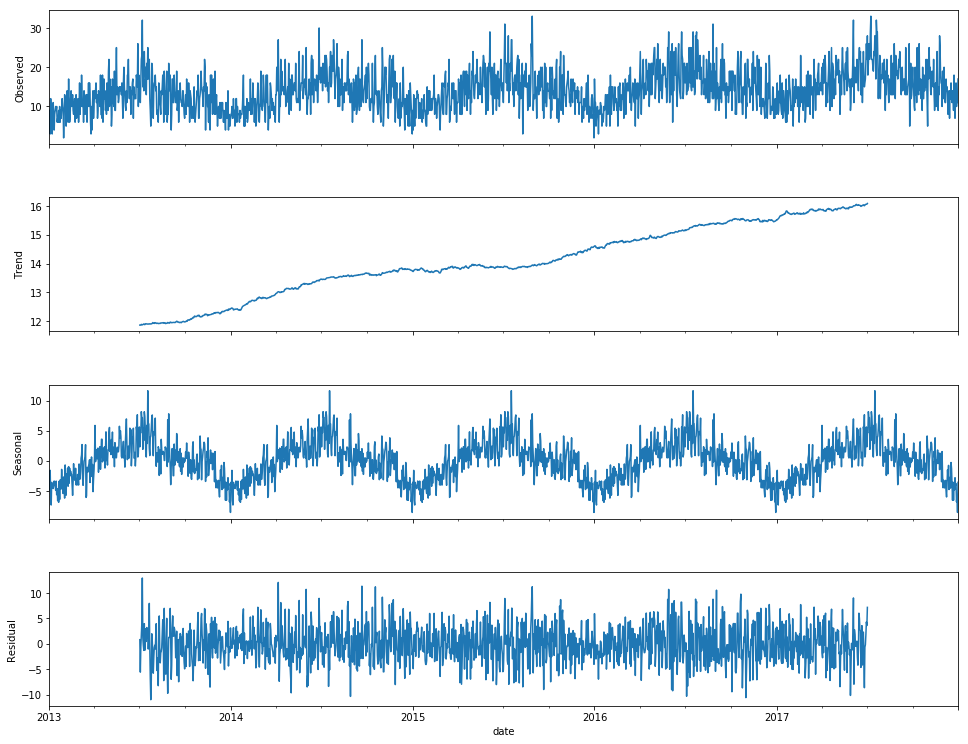

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [22]:
# stationary test

from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries, window = 12, cutoff = 0.01):
    '''Performing Dickey_Fuller Test and return p-value'''
    
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    
    pvalue = dftest[1]
    
    return pvalue


In [24]:
stationarity_test(df['sales'])

0.01043398901049512

The time series is stationary according to statistics but shows annual trend.

In [26]:
first_diff = df.sales - df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
stationarity_test(first_diff, window = 12)

1.8004882348894355e-28

p_value is extremely small thus null hypothesis is rejected. The time series is stationary after 1st differencing.
d=1
## MA and ACF

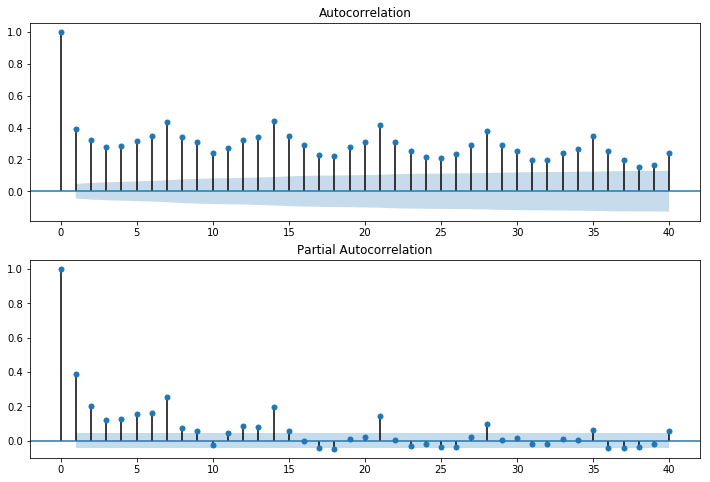

In [27]:
import statsmodels.api as sm

# Autocorrelation of the original data

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.sales, lags=40, ax=ax2)# , lags=40

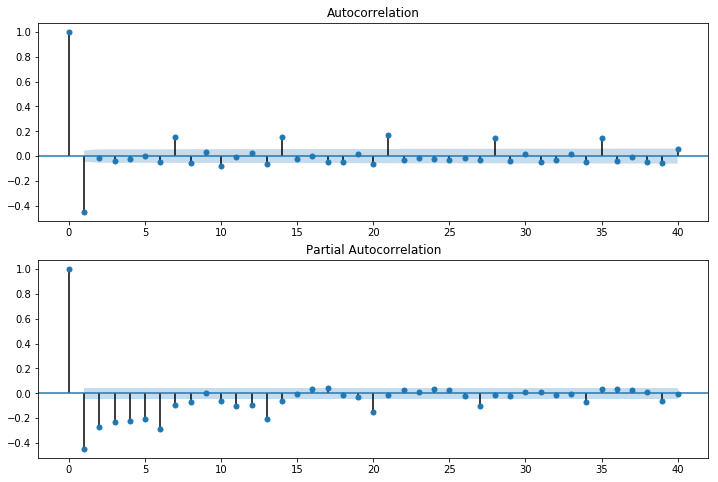

In [29]:
# Autocorrelation from first differencing

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)# , lags=40

In [31]:
arima_mod6 = sm.tsa.ARIMA(df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5278.166
Method:                       css-mle   S.D. of innovations              4.361
Date:                Fri, 01 Nov 2019   AIC                          10572.333
Time:                        15:47:18   BIC                          10616.407
Sample:                    01-02-2013   HQIC                         10588.591
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0033      0.024      0.138      0.890      -0.043       0.050
ar.L1.D.sales    -0.7903      0.022    -35.224      0.000      -0.834      -0.746
ar.L2.D.sales    -0.6750      0.027    -